# SWMM Hourly and Daily Precipitation Comparison

In this notebook we will download the 3-hour and daily precipitation datasets from NARR, and then run simulations on both datasets. We will then compare their outputs.

## 1) Imports

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import sys
import calendar

try:
    import wget  # Downloading Data
except:
    print('wget not found. Please run \'pip install wget\'.')

try:
    from osgeo import gdal  # GDAL
except:
    print('GDAL not found, please run \'conda install -c conda-forge gdal\'.')
    
try: 
    import rasterio as rio  # Modifying Raster datasets
except:
    print('Rasterio not found, please run \'pip install rasterio\'.')
     
path_to_gdal_calc = '/home/matas/anaconda3/envs/swmm/bin/'
sys.path.insert(0, path_to_gdal_calc)
try:
    import gdal_calc
except:
    print('gdal_calc not found, please specify the path to this file in gdal_path above')
    
try:
    import rasterstats as rs
except:
    print('rasterstats not found, please install it with \'pip install rasterstats\'')
    
try:
    import geopandas as gpd
except:
    print('geopands not found, please install it with \'pip install geopandas\'')
    
try:
    import matplotlib.pyplot as plt
except:
    print('matplotlib not found, please install it with \'pip install matplotlib\'')

GDAL not found, please run 'conda install -c conda-forge gdal'.
gdal_calc not found, please specify the path to this file in gdal_path above


## 2) Downloading the 3-Hour NetCDF Data for 2014

In [ ]:
download_dir = './hourly_netcdf/'
if not os.path.exists(download_dir):
    os.mkdir(download_dir)

In [ ]:
overwrite = False

name = 'apcp.2014.nc'
url = 'ftp://ftp.cdc.noaa.gov/Datasets/NARR/monolevel/'


if not os.path.exists(download_dir + name) or overwrite:
    print('Downloading', download_dir + name)
    wget.download(url + name, download_dir + name)
else:
    print('File already exists, not downloading')

## 3) Creating the Land Mask

#### Download

In [ ]:
if not os.path.exists('./land.nc'):
    print('File not found, attempting download.')
    download_url = 'ftp://ftp.cdc.noaa.gov/Datasets/NARR/time_invariant/land.nc'
    wget.download(download_url, './land.nc')
    
mask_file = glob.glob('./land.nc')
print('Successfully found land mask' if len(mask_file)==1 else 'Failed to find land mask')
mask_file = mask_file[0]

#### Projection

We use the EPSG 5070 projection, which matches our block group shapefile.

In [ ]:
proj = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=1,1,-1,0,0,0,0 +units=m +no_defs'
subdataset = 'land'
output_file = './land_mask'

warp_options = gdal.WarpOptions(options='-t_srs \"' + proj + '\" -of GTiff')
ds = gdal.Warp(srcDSOrSrcDSTab='NETCDF:' + mask_file + ':' + subdataset, destNameOrDestDS=output_file + '.geotiff', options=warp_options)
ds = None  # THIS IS VERY IMPORTANT
print('Successfully Warped Land Mask (' + output_file + '.geotiff)')

## 4) Land Mask Extension

We will extend the land mask by one pixel in each direction if the target pixel has no data. This is because the land mask excludes some block groups due to poor resolution.

In [ ]:
raster = rio.open(output_file + '.geotiff')

data = raster.read(1)

rows = data.shape[0]
cols = data.shape[1]
nodata = 0

data = np.ma.masked_equal(data,nodata)
output_data = np.copy(data)

for i in range(rows):
    for j in range(cols):
        if data.mask[i][j]:
            try:
                for x in range(-1,2):
                    for y in range(-1,2):
                        if not data.mask[i+x][j+y]:
                            output_data[i][j] = data[i+x][j+y]
            except IndexError:
                pass

with rio.open(output_file + '_extended.geotiff', 'w', **raster.profile) as dst:
    dst.write(output_data, 1)    

## 5) Converting NetCDF to GeoTIFF

**Note that this process will take a few minutes as the NETCDF has a lot of bands**

In [ ]:
netcdf = glob.glob('./hourly_netcdf/apcp.2014.nc')
print('Found NETCDF file' if netcdf else 'NETCDF File not found')
if not netcdf:
    raise KeyboardInterrupt
netcdf = netcdf[0]

In [ ]:
overwrite = False  # Overwrite existing GeoTIFFs or not

proj = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=1,1,-1,0,0,0,0 +units=m +no_defs'

# The warp options specify our target projection and output type (GeoTIFF)
warp_options = gdal.WarpOptions(options='-t_srs \"' + proj + '\" -of GTiff')
subdataset = 'apcp'

ds = gdal.Warp(srcDSOrSrcDSTab='NETCDF:' + netcdf + ':' + subdataset, destNameOrDestDS='./apcp.hourly.2014.geotiff', options=warp_options)
ds = None # Flush the file cache
print('Warped file ./apcp.hourly.2014.geotiff')

## 6) Masking the Data

#### Select the NetCDF and Land Mask

In [ ]:
netcdf = glob.glob('./apcp.hourly.2014.geotiff')
print('Found NETCDF file' if netcdf else 'NETCDF File not found')

mask_file = glob.glob('./land_mask_extended.geotiff')
print('Found Mask file' if mask_file else 'Mask file not found')

if not mask_file or not netcdf:
    print('Error! One or more required files not found.')
    raise KeyboardInterrupt
    
netcdf = netcdf[0]
mask_file = mask_file[0]

#### Mask Each Band

Note that this will take a while as there are 2920 bands!

In [ ]:
overwrite = False

output_directory = './hourly_masked_geotiffs/'
if not os.path.exists(output_directory):
    print('Making', output_directory)
    os.mkdir(output_directory)
    
raster = gdal.Open(netcdf)
band_count = raster.RasterCount

for band in range(1, band_count+1):
    print(str(band))
    outfile = output_directory + str(band) + '.geotiff'
    if not os.path.exists(outfile) or overwrite:
        gdal_calc.Calc('A*B', A=netcdf, B=mask_file, A_band=band, outfile=outfile, format='GTiff', NoDataValue=-9999.0)

## 7) Extracting the Data

The shape file california_chicago.gpkg is a modified version of the SelectBG_all_land_BGID_final shapefile and contains only two block groups. It can be found on the [GitHub repository](https://github.com/ncsa/CPRHD_WNV_USA_SWMM) in this Jupyter Notebook's folder.

In [ ]:
shape_file = './chicago_california_shape_file/california_chicago.gpkg'
geotiffs = glob.glob('./hourly_masked_geotiffs/*.geotiff')
if not shape_file or len(geotiffs) != 2920:
    print('Failed to find one or more files!')
    raise KeyboardInterrupt
else:
    print('Found all files successfully')
    
geotiffs.sort()

##### FIPS Code Conversion

We will import a function used to convert GEOID10 to the State, County names

Note that this function requires 'US_FIPS_Codes.csv' to be in the Jupyter Notebook directory. It can be found on the [GitHub repository](https://github.com/ncsa/CPRHD_WNV_USA_SWMM) along with the fips_converter file.

In [ ]:
path = '../../'
sys.path.insert(0,path)
from fips_converter import fips_conversion

In [ ]:
def state_name(code):
    return fips_conversion(code)[0]

In [ ]:
proj = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=1,1,-1,0,0,0,0 +units=m +no_defs'
shape_frame = gpd.read_file(shape_file)
shape_frame['GEOID10'] = shape_frame['GEOID10'].astype(str)

name = (geotiffs[0])[geotiffs[0].rfind('/')+1:geotiffs[0].rfind('.')]

output_columns = ['mean']
stats = rs.zonal_stats(shape_frame, geotiffs[0], stats=output_columns, all_touched=True)
frame = pd.DataFrame.from_dict(stats)
frame = frame.join(shape_frame['GEOID10'])
frame['NAME'] = frame['GEOID10'].apply(state_name)
frame = frame[['NAME', 'GEOID10', 'mean']]

columns = frame.columns.values
columns[2] = name
frame.columns = columns

# print(frame)

for file in geotiffs[1:]:
    name = file[file.rfind('/')+1:file.rfind('.')]
    stats = rs.zonal_stats(shape_frame, file, stats=output_columns, all_touched=True)
    subframe = pd.DataFrame.from_dict(stats)
    
    columns = subframe.columns.values
    columns[0] = name
    subframe.columns = columns
    frame = frame.join(subframe)
    
frame.to_pickle('./all_data.pkl')

## 8) Unit Conversion

We will convert NARR's units (mm) to the units we use in SWMM (inches).

In [ ]:
frame = pd.read_pickle('./all_data.pkl')
frame

In [ ]:
chicago_mm = frame.iloc[1][2:]
california_mm = frame.iloc[0][2:]

chicago = frame.iloc[1][2:].apply(lambda x: x / 25.40)  # 1 inch = 25.40 mm
california = frame.iloc[0][2:].apply(lambda x: x / 25.40)

In [ ]:
print(chicago_mm.max(), 'mm --', chicago.max(), 'inches')

In [ ]:
print(california_mm.max(), 'mm --', california.max(), 'inches')

#### Save the Data

In [ ]:
output_directory = './extracted_data/'
if not os.path.exists(output_directory):
    print('Making', output_directory)
    os.mkdir(output_directory)

chicago.to_pickle(output_directory + 'chicago.pkl')
california.to_pickle(output_directory + 'california.pkl')

 ## 9) Converting the Data to .CSV
 
 We need to convert the data to .csv in order to use it for input file generation.

#### Load Data

In [ ]:
dir = './extracted_data/'
chicago = pd.read_pickle(dir + 'chicago.pkl')
california = pd.read_pickle(dir + 'california.pkl')

#### Sort the index of the frame (1, 2, 3, ... , 2919, 2920)

In [ ]:
chicago.index = chicago.index.astype(int)
chicago = chicago.sort_index()

california.index = california.index.astype(int)
california = california.sort_index()


#### Save Data to CSV

In [ ]:
chicago.to_csv(dir + 'chicago.csv')
california.to_csv(dir + 'california.csv')

# Daily Data Processing

We will repeat the above process with the daily NetCDF for 2014.

## 1) Download Data

In [ ]:
download_dir = './daily_netcdf/'
if not os.path.exists(download_dir):
    print('Making', download_dir)
    os.mkdir(download_dir)

In [ ]:
download_url = 'ftp://ftp.cdc.noaa.gov/Datasets/NARR/Dailies/monolevel/'
name = 'apcp.2014.nc'

if not os.path.exists(download_dir + name):
    print('NetCDF file not found, attempting download')
    wget.download(download_url+name, download_dir + name)
    print('Download completed')

## 2) Convert the NetCDF to GeoTIFF

In [ ]:
netcdf = glob.glob('./daily_netcdf/apcp.2014.nc')
print('Found NETCDF file' if netcdf else 'NETCDF File not found')
if not netcdf:
    raise KeyboardInterrupt
netcdf = netcdf[0]

In [ ]:
overwrite = False  # Overwrite existing GeoTIFF or not

proj = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=1,1,-1,0,0,0,0 +units=m +no_defs'

# The warp options specify our target projection and output type (GeoTIFF)
warp_options = gdal.WarpOptions(options='-t_srs \"' + proj + '\" -of GTiff')
subdataset = 'apcp'
if not os.path.exists('./apcp.daily.2014.geotiff') or overwrite:
    ds = gdal.Warp(srcDSOrSrcDSTab='NETCDF:' + netcdf + ':' + subdataset, destNameOrDestDS='./apcp.daily.2014.geotiff', options=warp_options)
    ds = None # Flush the file cache
    print('Warped file ./apcp.daliy.2014.geotiff')

## 3) Masking each GeoTIFF

In [ ]:
netcdf = glob.glob('./apcp.daily.2014.geotiff')
print('Found NETCDF file' if netcdf else 'NETCDF File not found')
if not netcdf:
    raise KeyboardInterrupt
netcdf = netcdf[0]

mask_file = glob.glob('./land_mask_extended.geotiff')
print('Found mask file' if mask_file else 'Mask file not found')
if not mask_file:
    raise KeyboardInterrupt
mask_file = mask_file[0]

In [ ]:
overwrite = False

output_directory = './daily_masked_geotiffs/'
if not os.path.exists(output_directory):
    print('Making', output_directory)
    os.mkdir(output_directory)
    
raster = gdal.Open(netcdf)
band_count = raster.RasterCount
print(netcdf)
for band in range(1, band_count+1):
    outfile = output_directory + str(band) + '.geotiff'
    if not os.path.exists(outfile) or overwrite:
        gdal_calc.Calc('A*B', A=netcdf, B=mask_file, A_band=band, outfile=outfile, format='GTiff', NoDataValue=-9999.0)

## 4) Zonal Stats Data Extraction

In [ ]:
geotiffs = glob.glob('./daily_masked_geotiffs/*.geotiff')
if len(geotiffs) != 365:
    print('Failed to find all GeoTIFFs.')
    raise KeyboardInterrupt
else:
    print('Found all GeoTIFF files')

In [ ]:
shape_file = './chicago_california_shape_file/california_chicago.gpkg'
if not os.path.exists(shape_file):
    print('Failed to find shape file')
    raise KeyboardInterrupt
else:
    print('Found shape file')

##### FIPS Code Conversion

We will import a function used to convert GEOID10 to the State, County names

Note that this function requires 'US_FIPS_Codes.csv' to be in the Jupyter Notebook directory. It can be found on the [GitHub repository](https://github.com/ncsa/CPRHD_WNV_USA_SWMM) along with the fips_converter file.

In [ ]:
path = '../../'
sys.path.insert(0,path)
from fips_converter import fips_conversion

In [ ]:
def state_name(code):
    return fips_conversion(code)[0]

In [ ]:
output_directory = './daily_extracted_data/'
if not os.path.exists(output_directory):
    print('Making', output_directory)
    os.mkdir(output_directory)

In [ ]:
shape_frame = gpd.read_file(shape_file)
shape_frame['GEOID10'] = shape_frame['GEOID10'].astype(str)

# Set up the frame with the first file (we will join the other files onto this one)
name = (geotiffs[0])[geotiffs[0].rfind('/')+1:geotiffs[0].rfind('.')]

output_columns = ['mean']
stats = rs.zonal_stats(shape_frame, geotiffs[0], stats=output_columns, all_touched=True)
frame = pd.DataFrame.from_dict(stats)
frame = frame.join(shape_frame['GEOID10'])
frame['NAME'] = frame['GEOID10'].apply(state_name)
frame = frame[['NAME', 'GEOID10', 'mean']]

columns = frame.columns.values
columns[2] = name
frame.columns = columns

for file in geotiffs[1:]:
    name = file[file.rfind('/')+1:file.rfind('.')]
    stats = rs.zonal_stats(shape_frame, file, stats=output_columns, all_touched=True)
    subframe = pd.DataFrame.from_dict(stats)
    
    columns = subframe.columns.values
    columns[0] = name
    subframe.columns = columns
    frame = frame.join(subframe)
    
    
california=frame.iloc[0][2:].apply(lambda x: x / 25.40)
california.index = california.index.astype(int)
california = california.sort_index()

chicago = frame.iloc[1][2:].apply(lambda x: x / 25.40)
chicago.index = chicago.index.astype(int)
chicago = chicago.sort_index()

california.to_pickle(output_directory + 'california.pkl')
chicago.to_pickle(output_directory + 'chicago.pkl')
frame.to_pickle('./daily_data.pkl')

# Plots for Hourly and Daily Data

## Hourly Data
#### California

In [ ]:
date = [i for i in range(2920)]
xticks = [0,31,59,90,120,151,181,212,243,273,304,334]
xticks = [i * 8 for i in xticks]

In [ ]:
cali_data = pd.read_pickle('./hourly_extracted_data/california.pkl')
data = cali_data.to_numpy()

plt.figure(figsize=(8,8))
plt.title('California - 060375508003 - APCP 2014 - 3 Hour Accumulation')
width = 2.5

plt.bar(date, data, width)

plt.ylabel('Total Accumulated Precipitation (inches)')
plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
plt.savefig('./plots/california_inches_apcp_3hr.svg')

#### Chicago

In [ ]:
chicago_data = pd.read_pickle('./hourly_extracted_data/chicago.pkl')
data = chicago_data.to_numpy()

plt.figure(figsize=(8,8))
plt.title('Chicago - 170319800001 - APCP 2014 - 3 Hour Accumulation')
width = 2.5

plt.bar(date, data, width)

plt.ylabel('Total Accumulated Precipitation (inches)')
plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
plt.savefig('./plots/chicago_inches_apcp_3hr.svg')

## Daily Data 
#### California

In [ ]:
date = [i for i in range(1,366)]
xticks = [0,31,59,90,120,151,181,212,243,273,304,334]

In [ ]:
cali_data = pd.read_pickle('./daily_extracted_data/california.pkl')
data = cali_data.to_numpy()

plt.figure(figsize=(8,8))
plt.title('California - 060375508003 - APCP 2014 - Daily Accumulation')
width = 1.0

plt.bar(date, data, width)

plt.ylabel('Total Accumulated Precipitation (inches)')
plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
plt.savefig('./plots/california_inches_apcp_daily.svg')

#### Chicago

In [ ]:
chicago_data = pd.read_pickle('./daily_extracted_data/chicago.pkl')
data = chicago_data.to_numpy()

plt.figure(figsize=(8,8))
plt.title('Chicago - 170319800001 - APCP 2014 - Daily Accumulation')
width = 1.0

plt.bar(date, data, width)

plt.ylabel('Total Accumulated Precipitation (inches)')
plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
plt.savefig('./plots/chicago_inches_apcp_daily.svg')

# Data Validation

Ideally, the 3-hour accumulation data should sum across each day and be equal to the daily accumulation data. We will check if this is the case.

In [ ]:
for bg in ['california', 'chicago']:
#     for time in ['hourly', 'daily']:
    print(bg)

    hourly = pd.read_pickle('./hourly_extracted_data/' + bg + '.pkl')
    hourly_summed = hourly.groupby(hourly.index // 8).sum()
    
    daily = pd.read_pickle('./daily_extracted_data/' + bg + '.pkl')
    
    
    print('Total Daily Precipitation:', daily.sum().iloc[0])
    print('Total Hourly Precipitation:', hourly.sum().iloc[0])
    diff = daily - hourly_summed
    
    print('Mean:', diff.mean().iloc[0])
    print('Max:', diff.max().iloc[0])
    print('Min:', diff.min().iloc[0])
    diff = diff.to_numpy().flatten()
    

    

    overwrite = False
    plt.figure(figsize=(8,8))
    if bg is 'chicago':
        plt.title('Chicago - 170319800001 - Difference Between Hourly and Daily NARR Data', y=1.04)
    else:
        plt.title('California - 060375508003 - Difference Between Hourly and Daily NARR Data', y=1.04)
   
    date = [i for i in range(365)]
    xticks = [0,31,59,90,120,151,181,212,243,273,304,334]
    
    width = 1.0
    plt.bar(date, diff, width)
    plt.ylabel('Difference in Accumulated Precipitation (inches)')
    plt.xticks(xticks, calendar.month_name[1:13], rotation=-90)
    plt.tight_layout()
    
    outfile = './plots/' + bg + '_difference.svg'
    if not os.path.exists(outfile) or overwrite:
        print('Creating/overwriting', outfile)
        plt.savefig(outfile, dpi=900)
    

        
            


# Formatting the Timeseries Data
We will format the timeseries precipitation data so it can be copy/pasted into a premade Chicago / California input file.

SWMM Timeseries Format:

[TIMESERIES]

Name    Date    Time   Value


## Hourly Data

In [ ]:
for bg in ['chicago', 'california']:    
    timeseries_name = 'NARR_3HR'

    frame = pd.read_pickle('./hourly_extracted_data/' + bg + '.pkl').to_frame()
    
    date_rng = pd.date_range(start='1/1/2014', end='1/1/2015', freq='3H')
    date_rng = date_rng[:-1]  # Exclude 1/1/2015 00:00:00
#     date_rng = date_rng.strftime('%m/%d/%Y')
#     frame = frame.set_index(date_rng, drop=True)
    frame['date'] = date_rng.strftime('%m/%d/%Y')
    frame['time'] = date_rng.time.astype(str)
    frame['name'] = timeseries_name
    if bg == 'chicago':
        frame = frame[['name', 'date', 'time', 1]]
    else:
        frame = frame[['name', 'date', 'time', 0]]
    data = frame.to_numpy()

    np.savetxt('./hourly_extracted_data/' + bg + '_timeseries.txt', data, delimiter='\t', fmt='%s')
    
    


## Daily Data

In [ ]:
for bg in ['chicago', 'california']:    
    timeseries_name = 'NARR_DAILY'

    frame = pd.read_pickle('./daily_extracted_data/' + bg + '.pkl').to_frame()
    
    date_rng = pd.date_range(start='1/1/2014', end='1/1/2015', freq='1D')
    date_rng = date_rng[:-1]  # Exclude 1/1/2015
    
    frame['date'] = date_rng.strftime('%m/%d/%Y')
    frame['time'] = '00:00:00'
    frame['name'] = timeseries_name
    frame = frame[['name', 'date', 'time', frame.columns[0]]]
    print(frame)
    data = frame.to_numpy()


    np.savetxt('./daily_extracted_data/' + bg + '_timeseries.txt', data, delimiter='\t', fmt='%s')

# Creating the Input File

We will create input files for the No Green Infrastructure scenario for both Chicago (170319800001) and California (060375508003).

The code is already created in create_input_file.py in the root of this repository.

In [ ]:
# TODO

# Running the Simulation

In [ ]:
input_files = glob.glob('./swmm_analysis/simulation_files/*.inp')
for file in input_files:
    sim = Simulation(file)
    sim.execute()

# Extracting the Data


In [2]:
from swmmtoolbox import swmmtoolbox
import glob
import calendar
import matplotlib.pyplot as plt

In [ ]:
for bg in ['chicago', 'california']:
    for sim_type in ['3hr', 'daily', 'PRISM']:
        
        # For fixing the Runoff data (divide by subcatch area)
        if bg is 'chicago':
            area = 4933.82198249943
        else:
            area = 67.3855335000138
        
        output_file = glob.glob('./swmm_analysis/simulation_files/' + bg + '/*' + sim_type + '.out')[0]
#         extract_vars = swmmtoolbox.catalog(output_file)
#         extract_vars = list(filter(lambda x: x[0] == 'system', extract_vars))
#         print(extract_vars)
        extract_vars = [['system', 'Rainfall', 'Rainfall'],['system','Runoff','Runoff'],['system','Evaporation_infiltration','Evaporation_infiltration']]
        data = swmmtoolbox.extract(output_file, *extract_vars)
        
        data['system__Runoff'] = data['system__Runoff'].apply(lambda x: x / area)
        
        data.to_pickle('./swmm_analysis/extracted_simulation_data/' + bg + '_' + sim_type + '.pkl')
        data.to_csv('./swmm_analysis/extracted_simulation_data/' + bg + '_' + sim_type + '.csv')

## Data Comparison - Plots

We will compare the 3 hour data to the daily data

chicago
./swmm_analysis/plots/combined_plots/chicago_system__Rainfall.svg


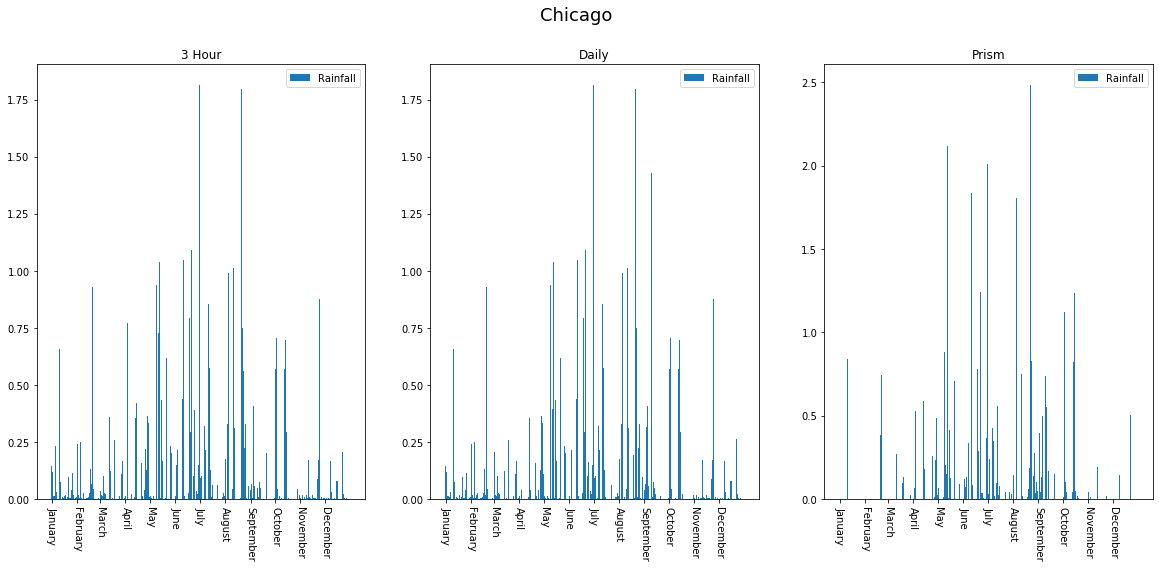

./swmm_analysis/plots/combined_plots/chicago_system__Evaporation_infiltration.svg


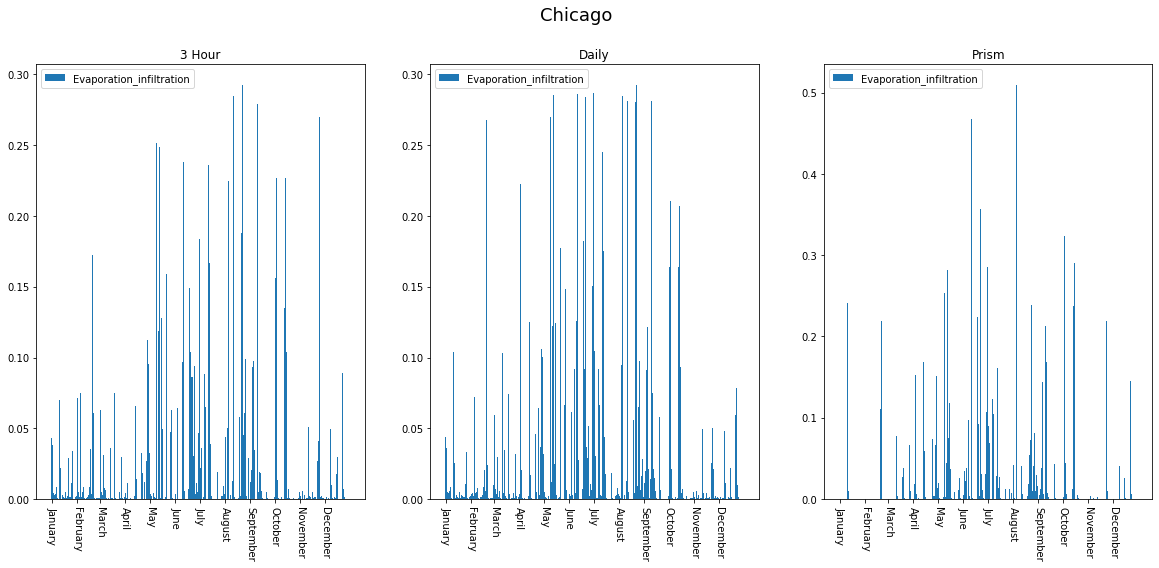

./swmm_analysis/plots/combined_plots/chicago_system__Runoff.svg


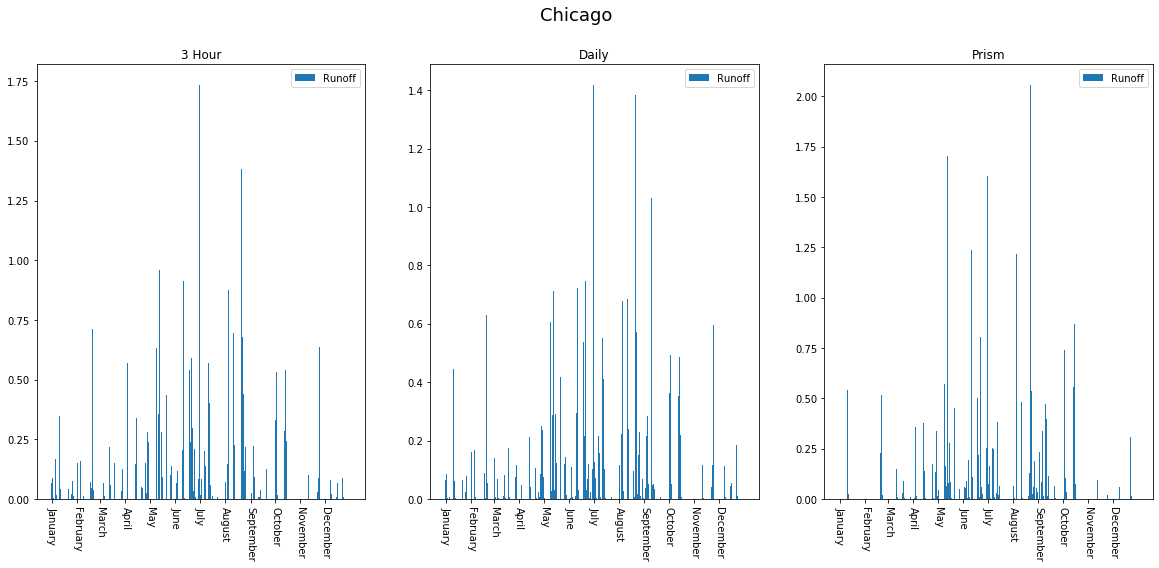

california
./swmm_analysis/plots/combined_plots/california_system__Rainfall.svg


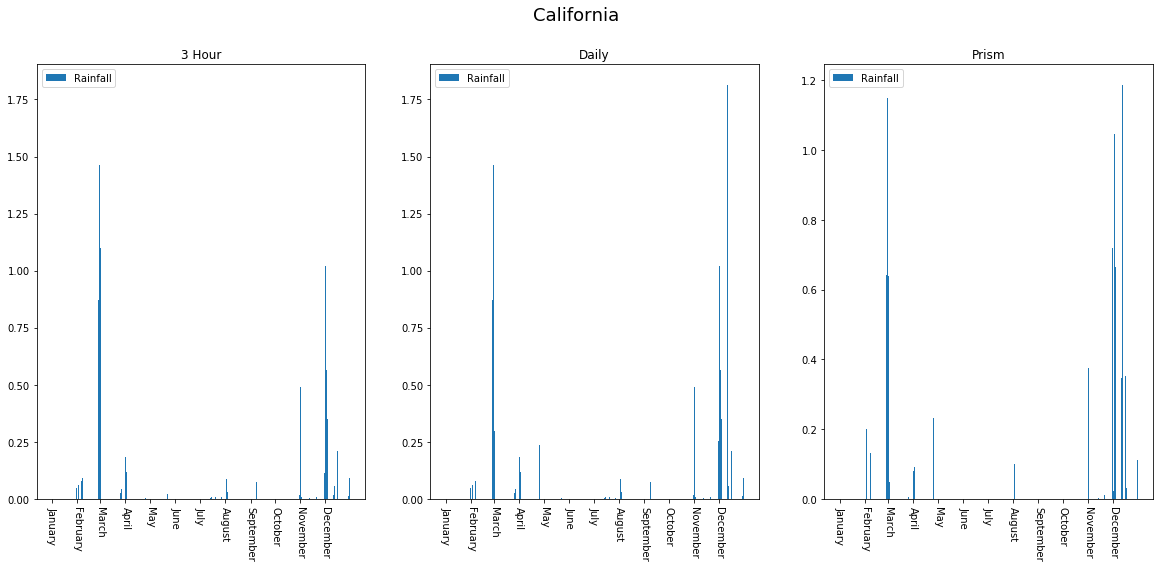

./swmm_analysis/plots/combined_plots/california_system__Evaporation_infiltration.svg


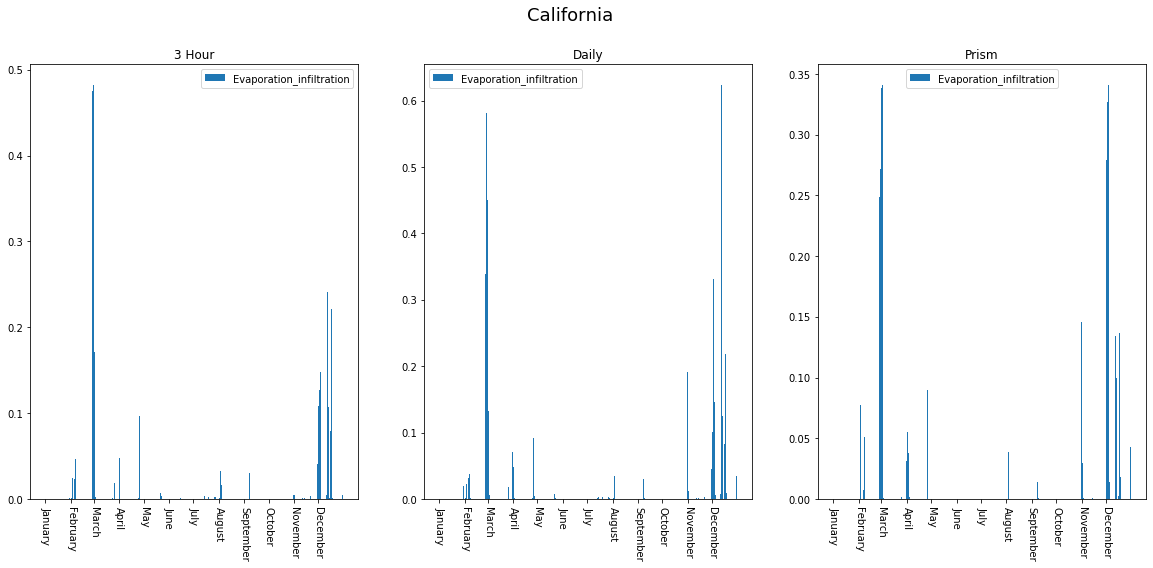

./swmm_analysis/plots/combined_plots/california_system__Runoff.svg


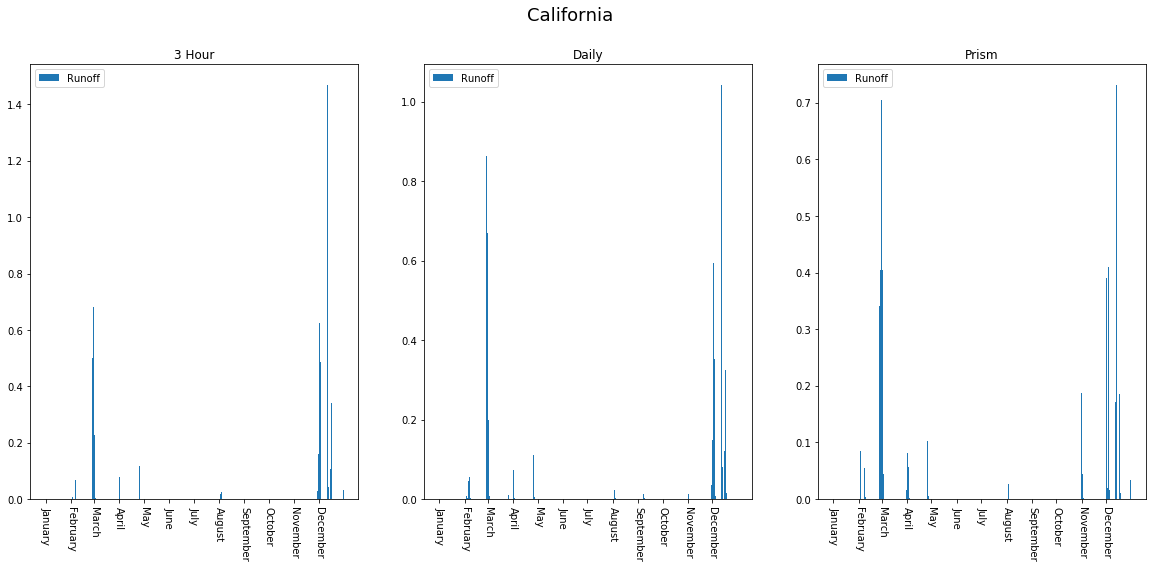

In [4]:
for bg in ['chicago', 'california']:    
    print(bg)
    name = bg[0].upper() + bg[1:]
    hour = pd.read_pickle('./swmm_analysis/extracted_simulation_data/' + bg + '_3hr.pkl').resample('d').sum()
    daily = pd.read_pickle('./swmm_analysis/extracted_simulation_data/' + bg + '_daily.pkl').resample('d').sum()
    prism = pd.read_pickle('./swmm_analysis/extracted_simulation_data/' + bg + '_PRISM.pkl').resample('d').sum()
    
    date = [i for i in range(365)]
    
    
    for data in ['system__Rainfall', 'system__Evaporation_infiltration', 'system__Runoff']:
        width = 1.0
        data_name = data[8:]
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

        fig.suptitle(name, fontsize=18)

        axes[0].set_title('3 Hour')
        axes[0].bar(date, hour[data], width, label=data_name)
        axes[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[0].legend()

        axes[1].set_title('Daily')
        axes[1].bar(date, daily[data], width, label=data_name)
        axes[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[1].legend()
        
        axes[2].set_title('Prism')
        axes[2].bar(date, prism[data], width, label=data_name)
        axes[2].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
        axes[2].set_xticklabels(calendar.month_name[1:13], rotation=-90)
        axes[2].legend()
    
        outfile = './swmm_analysis/plots/combined_plots/' + bg + '_' + data + '.svg'
        print(outfile)
        
        plt.autoscale()
        plt.savefig(outfile)
        plt.show()
        
    

# Plotting Difference

We will plot the difference between hourly and daily simulation data for each variable (Rainfall, Runoff, Infiltatration/Evaporation).

chicago
system__Rainfall
Max: 0.002101781778037548
Min: -1.4371471479535103e-07
Mean: 5.759214005991777e-06
system__Runoff
Max: 0.15757733492201936
Min: -0.3157233694113738
Mean: 0.00014277695200969165
system__Evaporation_infiltration
Max: 0.19761493935857288
Min: -0.07110393809853122
Mean: 0.003901756486905233


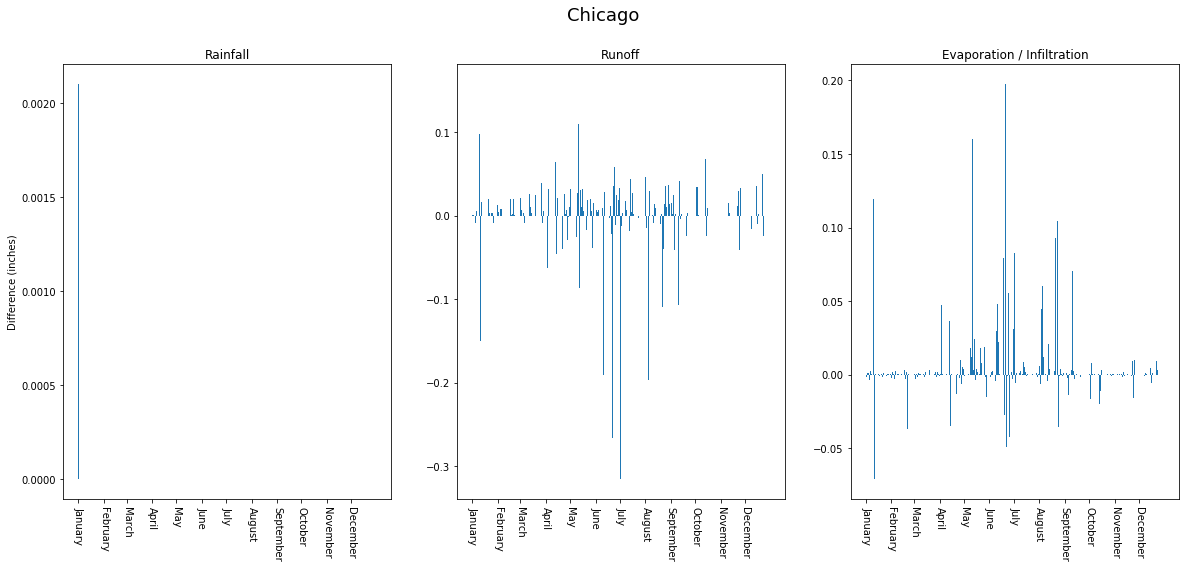

california
system__Rainfall
Max: 4.470348358154297e-08
Min: -1.3830140233039856e-07
Mean: -6.236613855485116e-10
system__Runoff
Max: 0.06305431577796664
Min: -0.4263597296762966
Mean: -0.0013915608473890175
system__Evaporation_infiltration
Max: 0.3822540359396953
Min: -0.03848380414274288
Mean: 0.0016743924531012503


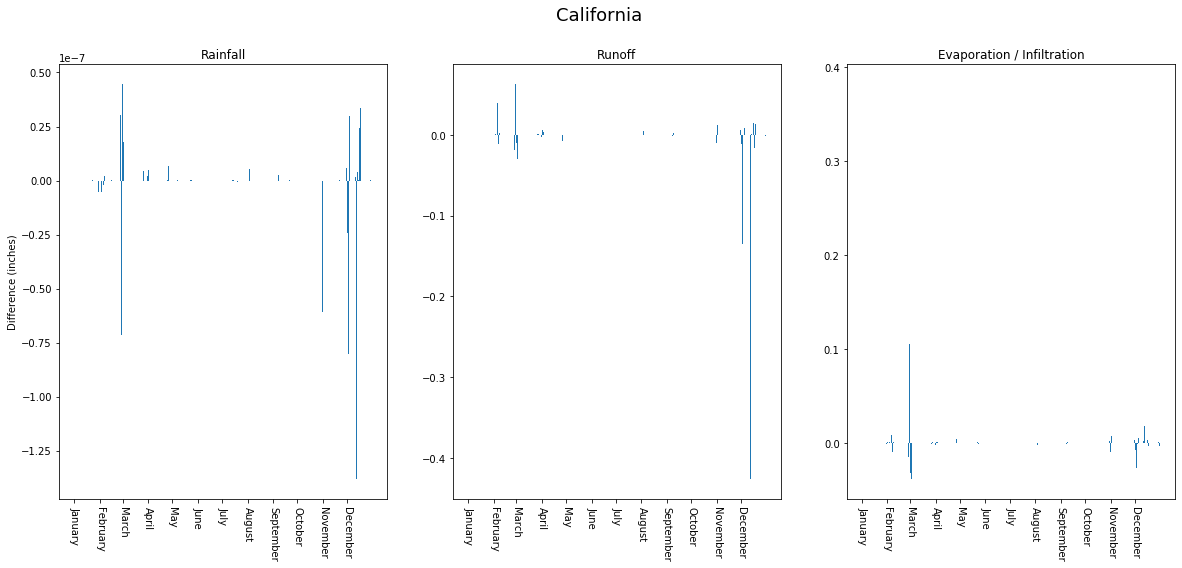

In [5]:
for bg in ['chicago', 'california']:
    print(bg)
    name = bg[0].upper() + bg[1:]
    
    hourly = pd.read_pickle('./swmm_analysis/extracted_simulation_data/' + bg + '_3hr.pkl')
    daily = pd.read_pickle('./swmm_analysis/extracted_simulation_data/' + bg + '_daily.pkl')
    
    difference = daily - hourly
    difference = difference.resample('d').sum()
    
    for variable in ['system__Rainfall', 'system__Runoff', 'system__Evaporation_infiltration']:
        print(variable)
        print('Max:', difference[variable].max())
        print('Min:', difference[variable].min())
        print('Mean:', difference[variable].mean())
        
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

    fig.suptitle(name, fontsize=18)

    axes[0].set_title('Rainfall')
    axes[0].set_ylabel('Difference (inches)')
    axes[0].bar(date, difference['system__Rainfall'], width, label='Rainfall')
    axes[0].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
    axes[0].set_xticklabels(calendar.month_name[1:13], rotation=-90)
#     axes[0].legend()

    axes[1].set_title('Runoff')
    axes[1].bar(date, difference['system__Runoff'], width, label='Runoff')
    axes[1].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
    axes[1].set_xticklabels(calendar.month_name[1:13], rotation=-90)
#     axes[1].legend()

    axes[2].set_title('Evaporation / Infiltration')
    axes[2].bar(date, difference['system__Evaporation_infiltration'], width, label='Evaporation_infiltration')
    axes[2].set_xticks([0,31,59,90,120,151,181,212,243,273,304,334])
    axes[2].set_xticklabels(calendar.month_name[1:13], rotation=-90)
#     axes[2].legend()
    
    plt.autoscale()

    outfile = './swmm_analysis/plots/difference/' + bg + '_difference.svg'
    plt.savefig(outfile)    
    plt.show()
